In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE
from plotly import express as ex
from os import path as pathlib,walk

%matplotlib inline

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

In [3]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=110):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32)
        return self
                

In [4]:
dataset = Dataset("./images/train/",100)
dataset.parse(progress_bar=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 926.33it/s]


Dataset Parser @ C:\workspace\facedet\notebooks\images\train

In [5]:
model = tf.keras.models.load_model("./model/")

In [6]:
pred = model.predict(dataset.x,batch_size=32)
tsne = TSNE(2,)
proj = tsne.fit_transform(pred)

In [8]:
def mse(x,y):
    return np.mean(np.square(np.subtract(x,y)))

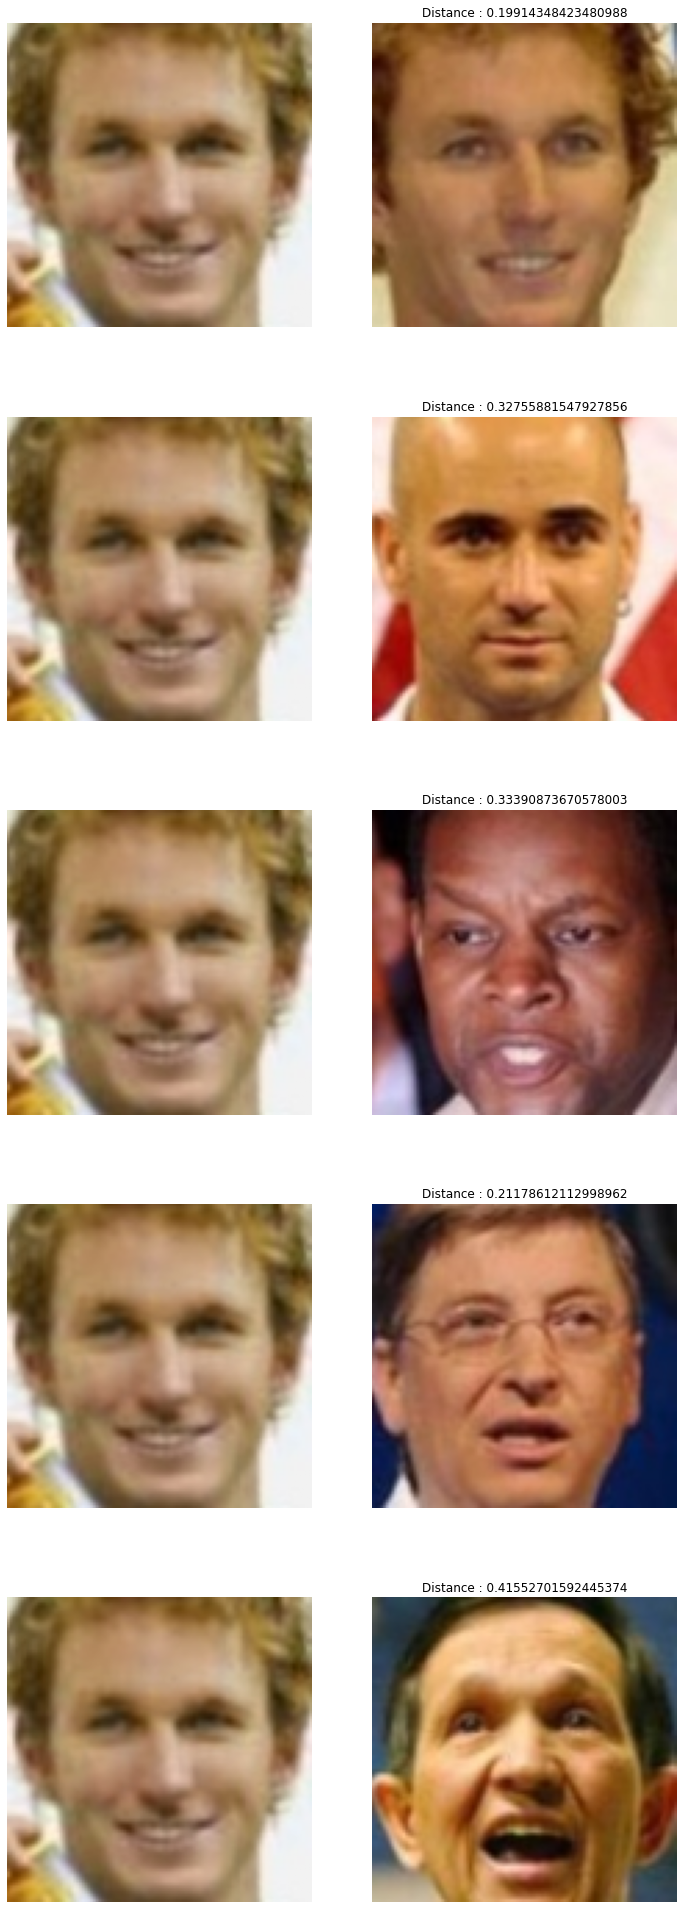

In [11]:
i = 0

face = dataset.x[i].copy()

face_true = model.predict(face.reshape(1,110,110,3))
fig,axes = plt.subplots(5,2,figsize=(12,35))

index = np.random.randint(0,len(dataset.x),5)

for (ax0,ax1),j in zip(axes,index):
    img = dataset.x[j]
    enc = model.predict(img.reshape(1,110,110,3))
    dist = mse(face_true,enc)
    ax0.imshow(face)
    ax1.imshow(img)
    ax1.set_title(f"Distance : {dist}")
    
    ax0.axis("off")
    ax1.axis("off")

face_next = dataset.x[i+1]
enc = model.predict(face_next.reshape(1,110,110,3))

dist = mse(face_true,enc)
axes[0,0].imshow(face)
axes[0,1].imshow(face_next)
axes[0,1].set_title(f"Distance : {dist}");